In [1]:
sc.setLogLevel("ERROR")

In [2]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
# read parquet files
hi_train_10 = spark.read.parquet("gs://st446-final-zqh/train_10.parquet")
hi_test_10 = spark.read.parquet("gs://st446-final-zqh/test_10.parquet")

In [4]:
hi_train_10.show(5)

+--------------------+--------------------+------+-----------------+--------------+-------------+-----------+-------+
|            business|                user|rating|       avg_rating|num_of_reviews|rating_binary|business_id|user_id|
+--------------------+--------------------+------+-----------------+--------------+-------------+-----------+-------+
|0x0:0x9edcb14b0cf...|10054904397250969...|   1.0|4.199999809265137|           278|            0|      899.0|18500.0|
|0x0:0x9edcb14b0cf...|10348849487277344...|   5.0|4.199999809265137|           278|            1|      899.0|30936.0|
|0x0:0x9edcb14b0cf...|10491152335097394...|   1.0|4.199999809265137|           278|            0|      899.0|36901.0|
|0x0:0x9edcb14b0cf...|10602167149068246...|   5.0|4.199999809265137|           278|            1|      899.0|41569.0|
|0x0:0x9edcb14b0cf...|10615637964195800...|   5.0|4.199999809265137|           278|            1|      899.0|42144.0|
+--------------------+--------------------+------+------

In [5]:
hi_train_10.count()

112082

In [6]:
hi_test_10.count()

12600

In [7]:
def grid_search(train_data, test_data):
    best_rmse = float("inf")
    best_model = None
    best_predictions = None
    best_rank = 0
    best_regParam = 0
    best_maxIter = 0
    for rank in [30, 40, 50, 60, 70]:
        for regParam in [0.01, 0.1, 1]:
            for maxIter in [15, 20]:
                als = ALS(rank=rank, maxIter=maxIter, regParam=regParam, userCol="user_id", itemCol="business_id", ratingCol="rating_binary", coldStartStrategy="drop")
                model = als.fit(train_data)
                predictions = model.transform(test_data)
                evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating_binary", predictionCol="prediction")
                rmse = evaluator.evaluate(predictions)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_predictions = predictions
                    best_rank = rank
                    best_regParam = regParam
                    best_maxIter = maxIter
                print(f"rank = {rank}, regParam = {regParam}, maxIter = {maxIter}, RMSE = {rmse}")
    return best_model,best_rmse,best_predictions,best_rank,best_regParam,best_maxIter

In [ ]:
best_model,best_rmse,best_predictions,best_rank,best_regParam,best_maxIter = grid_search(hi_train_10, hi_test_10)
print("The best rank is: ", best_rank)
print("The best regParam is: ", best_regParam)
print("The best maxIter is: ", best_maxIter)
print("The best rmse is: ", best_rmse)

rank = 30, regParam = 0.01, maxIter = 15, RMSE = 0.7320246330744322
rank = 30, regParam = 0.01, maxIter = 20, RMSE = 0.7106061637241091
rank = 30, regParam = 0.1, maxIter = 15, RMSE = 0.6741584848668426
rank = 30, regParam = 0.1, maxIter = 20, RMSE = 0.6544716458845068
rank = 30, regParam = 1, maxIter = 15, RMSE = 0.7679049583322071
rank = 30, regParam = 1, maxIter = 20, RMSE = 0.7679084975773054
rank = 40, regParam = 0.01, maxIter = 15, RMSE = 0.7217016088033632
rank = 40, regParam = 0.01, maxIter = 20, RMSE = 0.6993464226679247
rank = 40, regParam = 0.1, maxIter = 15, RMSE = 0.6671805744176955
rank = 40, regParam = 0.1, maxIter = 20, RMSE = 0.6495572414440484
rank = 40, regParam = 1, maxIter = 15, RMSE = 0.7679082979876338
rank = 40, regParam = 1, maxIter = 20, RMSE = 0.7679108505119969
rank = 50, regParam = 0.01, maxIter = 15, RMSE = 0.721666673590909
rank = 50, regParam = 0.01, maxIter = 20, RMSE = 0.6979689630918878
rank = 50, regParam = 0.1, maxIter = 15, RMSE = 0.671281241151931

In [ ]:
best_predictions.show(5)

+--------------------+--------------------+------+------------------+--------------+-------------+-----------+-------+----------+
|            business|                user|rating|        avg_rating|num_of_reviews|rating_binary|business_id|user_id|prediction|
+--------------------+--------------------+------+------------------+--------------+-------------+-----------+-------+----------+
|0x79524b16dae802b...|10961168130206631...|   5.0|3.9000000953674316|           745|            1|      148.0| 4699.0|0.56818366|
|0x79524b16dae802b...|11477320011212580...|   2.0|3.9000000953674316|           745|            0|      148.0|14217.0|       0.0|
|0x7c005df17d8e762...|10836871122591725...|   3.0| 3.700000047683716|           478|            0|      463.0|10682.0|0.22755454|
|0x79540e5a1bf7b75...|11521845562523828...|   4.0| 4.199999809265137|           366|            0|      471.0|  455.0|0.16757835|
|0x79540e5a1bf7b75...|11533063220536881...|   4.0| 4.199999809265137|           366|      

In [ ]:
from pyspark.sql.functions import when, col

# define a function to evaluate the model
def evaluate_model(predictions):
    # calculate TP, FP, TN, FN
    TP = predictions.filter((col('prediction_binary') == 1) & (col('rating_binary') == 1)).count()
    FP = predictions.filter((col('prediction_binary') == 1) & (col('rating_binary') == 0)).count()
    TN = predictions.filter((col('prediction_binary') == 0) & (col('rating_binary') == 0)).count()
    FN = predictions.filter((col('prediction_binary') == 0) & (col('rating_binary') == 1)).count()

    # calculate Precision, Recall, F1-Score
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    # calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # calculate Specificity
    specificity = TN / (TN + FP) if (TN + FP) else 0

    return accuracy, precision, recall, f1_score, specificity

In [ ]:
best_predictions = best_predictions.withColumn('prediction_binary', when(col('prediction') > 0, 1).otherwise(0))
accuracy, precision, recall, f1_score, specificity = evaluate_model(best_predictions)
print("The accuracy of the ALS model is:", accuracy)
print("The precision of the ALS model is:", precision)
print("The recall of the ALS model is:", recall)
print("The f1_score of the ALS model is:", f1_score)
print("The specificity of the ALS model is:", specificity)

The accuracy of the ALS model is: 0.6181410974244121
The precision of the ALS model is: 0.6636107193229901
The recall of the ALS model is: 0.7147740220281048
The f1_score of the ALS model is: 0.6882428231852258
The specificity of the ALS model is: 0.47925764192139736


In [ ]:
# normalize the 'prediction' into 0-1

max_prediction = best_predictions.agg({"prediction": "max"}).collect()[0][0]
min_prediction = best_predictions.agg({"prediction": "min"}).collect()[0][0]

best_predictions = best_predictions.withColumn("probability", (best_predictions["prediction"] - min_prediction) / (max_prediction - min_prediction))

best_predictions.show(5)

+--------------------+--------------------+------+------------------+--------------+-------------+-----------+-------+----------+-----------------+-------------------+
|            business|                user|rating|        avg_rating|num_of_reviews|rating_binary|business_id|user_id|prediction|prediction_binary|        probability|
+--------------------+--------------------+------+------------------+--------------+-------------+-----------+-------+----------+-----------------+-------------------+
|0x79524b16dae802b...|11477320011212580...|   2.0|3.9000000953674316|           745|            0|      148.0|14217.0|       0.0|                0| 0.2663507808423505|
|0x79524b16dae802b...|10961168130206631...|   5.0|3.9000000953674316|           745|            1|      148.0| 4699.0|0.56818366|                1| 0.7294143367227144|
|0x7c005df17d8e762...|10836871122591725...|   3.0| 3.700000047683716|           478|            0|      463.0|10682.0|0.22755454|                1|  0.451805280

In [ ]:
best_predictions.write.format("parquet").save("gs://st446-final-zqh/best_predictions_10.parquet")

In [ ]:
best_predictions_pd = best_predictions.toPandas()
print("done")

done


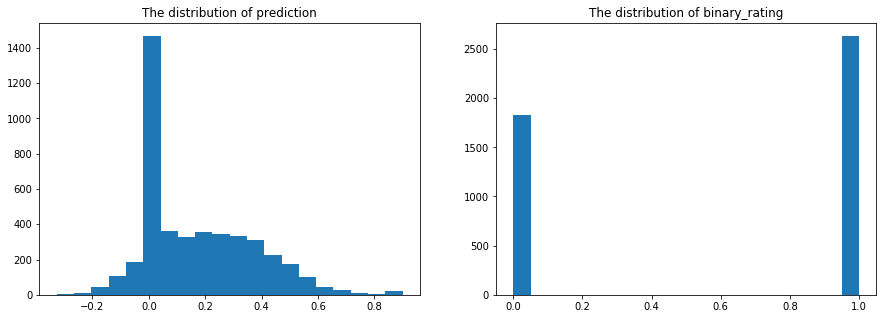

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# draw the ditrbution of prediction column
axs[0].hist(best_predictions_pd["prediction"], bins=20)
axs[0].set_title("The distribution of prediction")

# draw the ditrbution of rating column
axs[1].hist(best_predictions_pd["rating_binary"], bins=20)
axs[1].set_title("The distribution of binary_rating")

plt.show()

In [21]:
# draw the precision-recall curve and ROC curve
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(best_predictions_pd["rating_binary"], best_predictions_pd["probability"])
auc_score_pr = auc(recall, precision)

# calculate the roc curve
fpr, tpr, _ = roc_curve(best_predictions_pd["rating_binary"], best_predictions_pd["probability"])

# calculate the auc
auc_score = auc(fpr, tpr)

print(auc_score_pr)
print(auc_score)

0.7066437549175643
0.6181917823327368


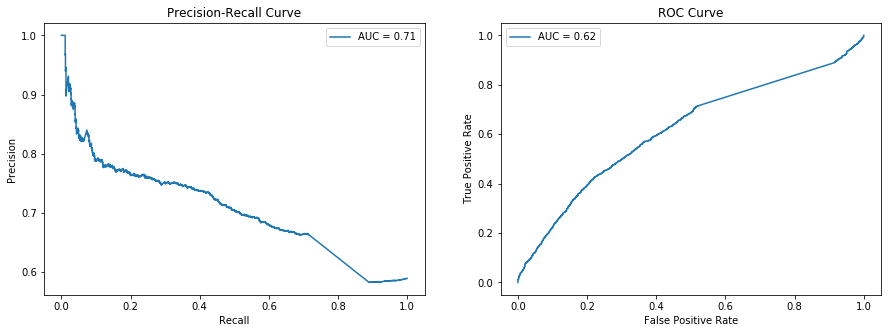

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# draw the precision-recall curve
axs[0].plot(recall, precision, label="AUC = {:.2f}".format(auc_score_pr))
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].set_title("Precision-Recall Curve")
axs[0].legend()

# draw the roc curve
axs[1].plot(fpr, tpr, label="AUC = {:.2f}".format(auc_score))
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title("ROC Curve")
axs[1].legend()

plt.show()